In [8]:
# For running inference on the TF-Hub module.
import tensorflow as tf
import os
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import tarfile
import shutil

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.15.0
The following GPU devices are available: 


In [9]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())


  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str, str(i+1)])
      np.copyto(image, np.array(image_pil))
  return image

In [16]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']


In [17]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [18]:
scores_list = []

In [19]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  result = detector(converted_img)

  result = {key:value.numpy() for key,value in result.items()}
  print("Found %d objects." % len(result["detection_scores"]))

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
  #form a list of confidence score of all images
  scores_list.append(result["detection_scores"])
  display_image(image_with_boxes)

In [25]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  "https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcRy5QMODyHm-LaMpgXOqMIUHPbQ-Y51jAZR_UJYC-9Dv1IL3ovh",
  "https://www.livemint.com/lm-img/img/2024/02/24/1600x900/ANI-20230120149-0_1677604856085_1677604856085_1708742376152.jpg",
  "https://images.rawpixel.com/image_png_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIzLTA4L3Jhd3BpeGVsX29mZmljZV80X3Bob3RvX29mX2FfY2l0eV9idWlsZGluZ19pc29sYXRlZF9vbl9hX3doaXRlX18zOGE1NjFhNC1iYzY0LTQwMGUtOTYyYS1lOTczMTU1NjhlODVfMS5wbmc.png",
  "https://images.unsplash.com/photo-1592670130429-fa412d400f50?q=80&w=1000&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8d2lsZCUyMGFuaW1hbHxlbnwwfHwwfHx8MA%3D%3D",
  "https://keralakaumudi.com/web-news/en/2023/05/NMAN0413506/image/tiger.1.559435.jpg",
  "https://cdn.britannica.com/92/194292-138-108C4879/Homo-species-debates-human.jpg?w=800&h=450&c=crop",
  "https://st2.depositphotos.com/1159452/6507/i/450/depositphotos_65071431-stock-photo-winking-people-six-expressions-people.jpg",
  "https://img.freepik.com/free-photo/painting-mountain-lake-with-mountain-background_188544-9126.jpg?size=626&ext=jpg&ga=GA1.1.44546679.1715990400&semt=sph",
  "https://i0.wp.com/picjumbo.com/wp-content/uploads/breathtaking-bali-nature-free-photo.jpg?w=600&quality=80",
  "https://t3.ftcdn.net/jpg/01/13/46/78/360_F_113467839_JA7ZqfYTcIFQWAkwMf3mVmhqXr7ZOgEX.jpg",
  "https://media.istockphoto.com/id/1490901300/photo/young-colleagues-cooperating-while-working-on-a-computer-in-the-office.webp?b=1&s=170667a&w=0&k=20&c=WQ_42khug17ZsOrr039hqO3AlqBi3Zs2oxR500C6Ag0=",

  ]


def detect_img(image_url):
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path
               )


Image downloaded to /tmp/tmp4o8yma7g.jpg.
Found 100 objects.


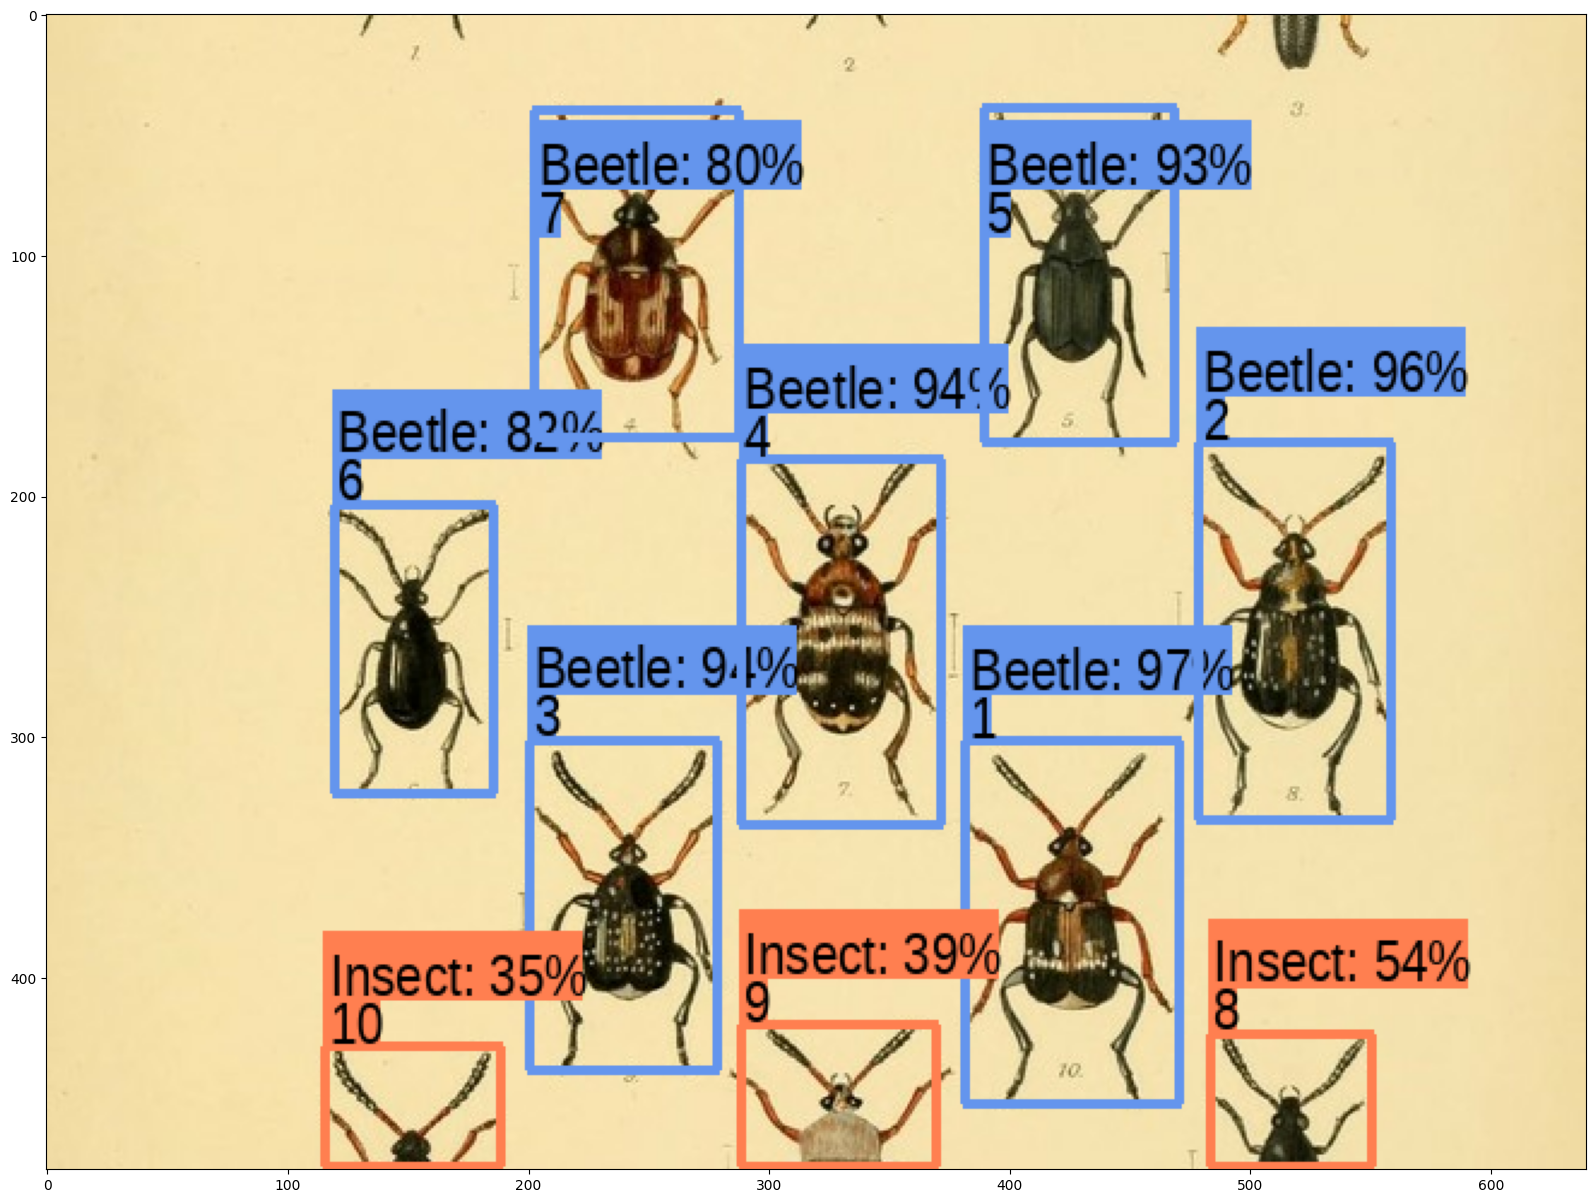

In [21]:
detect_img(image_urls[0])

In [30]:
for i in range(len(scores_list)):
  scores_list[i] = scores_list[i][:10]
  scores_list[i] = np.array(scores_list[i])
print(scores_list)

[array([0.9764089 , 0.96183306, 0.9465617 , 0.9448294 , 0.9365696 ,
       0.8224317 , 0.80256635, 0.5496529 , 0.39486495, 0.35203376],
      dtype=float32), array([0.94342995, 0.897431  , 0.80805296, 0.7741199 , 0.7174541 ,
       0.35079494, 0.21762127, 0.2003282 , 0.13067001, 0.1159277 ],
      dtype=float32), array([0.9800776 , 0.87387145, 0.86954737, 0.7000615 , 0.5079343 ,
       0.46094668, 0.17383765, 0.16859949, 0.16758697, 0.15534629],
      dtype=float32), array([0.96241224, 0.92560565, 0.9010387 , 0.73236895, 0.7287416 ,
       0.4217046 , 0.09455109, 0.06624067, 0.05937152, 0.05894092],
      dtype=float32), array([0.8586951 , 0.828104  , 0.81137854, 0.8112618 , 0.81075615,
       0.77886784, 0.77827686, 0.7647991 , 0.760891  , 0.74424636],
      dtype=float32), array([0.7493876 , 0.7367355 , 0.73082876, 0.7035838 , 0.53505963,
       0.44717714, 0.4394563 , 0.4154294 , 0.41197142, 0.4089818 ],
      dtype=float32), array([0.9945877 , 0.9935366 , 0.51433563, 0.2752278 , 0.

In [33]:
is_numpy_array = isinstance(scores_list[0], np.ndarray)

print(is_numpy_array)

True


In [26]:
len(image_urls)

14

In [23]:
for i in range(1, len(image_urls)):
  detect_img(image_urls[i])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
true_labels_list = [
    np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
    np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
    np.array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0]),
    np.array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0]),
    np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
    np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
    np.array([1, 1, 1, 1, 1, 0, 1, 0, 0, 1]),
    np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
    np.array([1, 1, 0, 1, 1, 1, 0, 1, 1, 0]),
    np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
    np.array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]),
    np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0]),
    np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
    np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),

]


In [34]:
import numpy as np

def calculate_precision_recall(scores, true_labels, threshold):
    predicted_labels = (scores >= threshold).astype(int)

    TP = np.sum((predicted_labels == 1) & (true_labels == 1))
    FP = np.sum((predicted_labels == 1) & (true_labels == 0))
    FN = np.sum((predicted_labels == 0) & (true_labels == 1))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0

    return precision, recall

def calculate_mAP(scores, true_labels):
    # Sort predictions by confidence scores
    sorted_indices = np.argsort(scores)[::-1]
    sorted_labels = true_labels[sorted_indices]

    cum_TP = np.cumsum(sorted_labels)

    precisions = cum_TP / np.arange(1, len(scores) + 1)
    recalls = cum_TP / np.sum(true_labels)

    ap = np.sum((recalls[1:] - recalls[:-1]) * precisions[:-1])

    return ap

def evaluate_precision_recall_mAP(scores_list, true_labels_list, threshold=0.5):
    precisions = []
    recalls = []
    aps = []

    for scores, true_labels in zip(scores_list, true_labels_list):
        precision, recall = calculate_precision_recall(scores, true_labels, threshold)
        ap = calculate_mAP(scores, true_labels)

        precisions.append(precision)
        recalls.append(recall)
        aps.append(ap)

    precision = np.mean(precisions)
    recall = np.mean(recalls)
    mAP = np.mean(aps)

    return precision, recall, mAP

# Example usage
scores_list = [
    np.array([0.8, 0.7, 0.6, 0.4, 0.9]),
    np.array([0.6, 0.5, 0.7, 0.3, 0.8])
]

true_labels_list = [
    np.array([1, 0, 1, 0, 1]),
    np.array([0, 1, 1, 0, 1])
]

precision, recall, mAP = evaluate_precision_recall_mAP(scores_list, true_labels_list)
print("Precision:", precision)
print("Recall:", recall)
print("mAP:", mAP)


Precision: 0.75
Recall: 1.0
mAP: 0.5555555555555556
